In [1]:
import pandas as pd
import numpy as np

In [2]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv --output housing.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1390k  100 1390k    0     0  1110k      0  0:00:01  0:00:01 --:--:-- 1080k:00:01  0:00:01 --:--:-- 1119k


Load the data.

In [3]:
df = pd.read_csv('housing.csv')

print(len(df))

df.head()

20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Look at the median_house_value variable. Does it have a long tail?

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

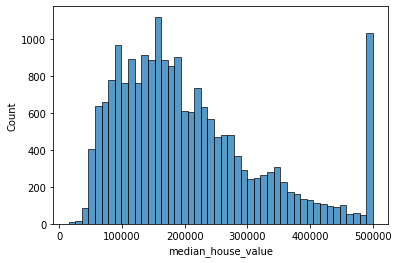

In [6]:
%matplotlib inline

import seaborn as sns

sns.histplot(df['median_house_value'])

For the rest of the homework, you'll need to use only these columns:

In [7]:
df = df[['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']]

Q1:
Find a feature with missing values. How many missing values does it have?

In [8]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Q2: 
What's the median (50% percentile) for variable 'population'?

In [9]:
df['population'].median()

1166.0

Split the data
Shuffle the initial dataset, use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Make sure that the target value ('median_house_value') is not in your dataframe.
Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [10]:
n = len(df)

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = int(n*0.6)
n, n_val, n_test, n_train

(20640, 4128, 4128, 12384)

In [11]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

In [14]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

Q3:
We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.
Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!
Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?

In [47]:
# We have two options: fill the missing values with 0 or with the mean of the variable.
# For each, train a linear regression model without regularization
# For computing the mean, use the training only!
# Use the validation dataset to evaluate the models and compare the RMSE of each option.
# Round the RMSE scores to 2 decimal digits using round(score, 2)
# Which option gives better RMSE?

# fill with 0 and train a linear regression model
df_train_0 = df_train.fillna(0)


def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

# train the model 
w0, w = train_linear_regression(df_train_0, y_train)

# make predictions
y_pred = w0 + df_train_0.dot(w)

# calculate the RMSE
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

rmse_0 = round(rmse(y_train, y_pred), 2)

print(rmse_0)

# fill with mean and train a linear regression model
df_train_mean = df_train.fillna(df_train.total_bedrooms.mean())

# train the model
w0, w = train_linear_regression(df_train_mean, y_train)

# make predictions
y_pred = w0 + df_train_mean.dot(w)

# calculate the RMSE
rmse_mean = round(rmse(y_train, y_pred), 2)

print(rmse_mean)


0.0
0.0


Q4:
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?

In [34]:
# train a regularized linear regression model with r=0.001
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [32]:
df_train = df_train.fillna(0)

In [35]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train.values, y_train, r=r)
    y_pred = w_0 + df_train.values.dot(w)
    rmse_train = rmse(y_train, y_pred)

    y_pred = w_0 + df_val.values.dot(w)
    rmse_val = rmse(y_val, y_pred)

    print(r, round(rmse_train, 2), round(rmse_val, 2))

0 0.34 0.33
1e-06 0.34 0.33
0.0001 0.34 0.33
0.001 0.34 0.33
0.01 0.34 0.33
0.1 0.34 0.33
1 0.35 0.33
5 0.35 0.34
10 0.35 0.34


Q5:
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))


In [41]:
# try different seed values for the random shuffle and see how the RMSE changes
rmse_scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed
    np.random.shuffle(idx)

    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_train = int(n*0.6)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)

    w0, w = train_linear_regression(df_train.values, y_train)
    y_pred = w0 + df_train.values.dot(w)
    rmse_train = rmse(y_train, y_pred)
 

    y_pred = w0 + df_val.values.dot(w)
    rmse_val = rmse(y_val, y_pred)
    rmse_scores.append(rmse_val)

    print(seed, round(rmse_train, 3), round(rmse_val, 3))

# print the standard deviation of the RMSE scores, round it to 3 decimal places
round(np.std(rmse_scores), 3)

0 0.567 0.574
1 0.567 0.574
2 0.567 0.574
3 0.567 0.574
4 0.567 0.574
5 0.567 0.574
6 0.567 0.574
7 0.567 0.574
8 0.567 0.574
9 0.567 0.574


0.0

Q6:
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [42]:
# Split the dataset like previously, use seed 9.
# Fill the missing values with 0 and train a model with r=0.001.

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

n_test = int(n*0.2)
n_train = int(n*0.8)

df_train = df.iloc[idx[:n_train]]
df_test = df.iloc[idx[n_train:]]
y_train = df_train.median_house_value.values
y_test = df_test.median_house_value.values

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

w0, w = train_linear_regression_reg(df_train.values, y_train, r=0.001)

y_pred = w0 + df_test.values.dot(w)
rmse_test = rmse(y_test, y_pred)

rmse_test


1.0849898528729166e-06